# Transfer Learning

Na maioria das vezes, você não vai querer treinar toda uma rede convolucional. O treinamento moderno do ConvNets em grandes datasets como o ImageNet leva semanas em várias GPUs.
> Em vez disso, a maioria das pessoas usa uma rede pré-treinada como um extrator de features fixo ou como uma rede inicial para ser treinada.

Neste notebook, você usará a [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) treinada no [dataset ImageNet](http://www.image-net.org/) como um extrator de features. Abaixo está um diagrama da arquitetura VGGNet, com uma série de camadas convolucionais e de maxpooling, e depois três camadas lineares no final, que classificam as 1000 classes encontradas no dataset ImageNet.

<img src="notebook_ims/vgg_16_architecture.png" width=700px>

A VGGNet é ótima porque é simples e tem ótimo desempenho, ficando em segundo lugar na competição ImageNet. A idéia aqui é que mantenhamos todas as camadas convolucionais, mas que a gente **substitua a camada linear final** por nosso próprio classificador. Dessa forma, podemos usar a VGGNet como um extrator de features fixo para nossas imagens e treinar facilmente um classificador simples.
* Use todos, exceto a última camada linear, como um extrator de features fixo.
* Defina uma nova camada final de classificação e aplique-a em uma tarefa de nossa escolha!

Você pode ler mais sobre transfer learning nas [notas de aula do curso do CS231n Stanford](http://cs231n.github.io/transfer-learning/).

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Flores

Aqui vamos usar a VGGNet para classificar imagens de flores. Começaremos, como sempre, importando nossos recursos habituais e verificando se podemos treinar nosso modelo em GPU.

### Download dos dados

Faça o download dos dados das flores [neste link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/Setembro/5baa60a0_flower-photos/flower-photos.zip), salve-os no diretório raíz deste notebook e extraia o arquivo zip para obter o diretório `flower_photos/`. **Verifique se o diretório tem esse nome exato para acessar os dados: flower_photos**.

In [2]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim


%matplotlib inline

In [3]:
# Checando se CUDA está disponível
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


## Load and Transform our Data

Iremos utilizar a classe [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) do PyTorch que facilita a carga dos dados a partir do disco rígido. Por exemplo, as imagens de treinamento estão ordenadas em um caminho que possui o seguinte padrão:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Nesse caso, o diretório raíz para treinamento é `flower_photos/train/` e as classes são os nomes dos tipos das flores.

In [4]:
# definindo diretórios de treinamento e teste
data_dir = "/content/drive/My Drive/flower_photos/"
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes são pastas em cada diretório com esses nomes
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Transformando os Dados

Ao realizar transfer learning, precisamos modelar os dados de entrada de tal forma que possuam o mesmo formato que a rede pré-treinada espera receber. A VGG16 espera receber, como entrada, imagens quadradas de dimensões 224, então precisamos reformatar as imagens de flores para este formato.

In [5]:
# carregando e transformando dados usando ImageFolder

# VGG-16 recebe imagens de entrada 224x224, então vamos redimensioná-las
data_transform_train = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                           transforms.RandomRotation(degrees=15),
                                           transforms.ColorJitter(),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.CenterCrop(size=224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])
                                          ])


data_transform_test = transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])
                                         ])


train_data = datasets.ImageFolder(train_dir, transform=data_transform_train)
test_data = datasets.ImageFolder(test_dir, transform=data_transform_test)

# vamos ver algumas estatísticas das imagens
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


In [6]:
# obtain training indices that will be used for validation
valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [7]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### DataLoaders e Data Visualization

In [8]:
batch_size = 20
num_workers=1

# data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

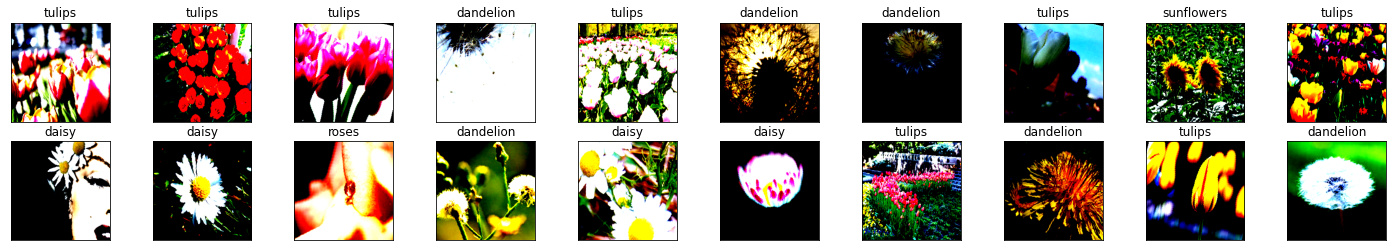

In [9]:
# Visualizando alguns dados

# Obtendo um batch do conjunto de treinamento
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convertemos a imagem para numpy para podermos visualizá-la

# Visualizando as imagens do batch junto com suas respectivas labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

---
## Definindo o Modelo

Para definir o modelo, vamos seguir os seguintes passos:
1. Carregar o modelo RESNET152pré-treinado
2. "Congelar" todos os parâmetros, para que a extração de características fique fixa
3. Remover a última camada
4. Substituir a última camada por um classificador linear novo

**Congelar simplesmente significa que os parâmetros no modelo pré-treinado *não* serão alterados durante o treinamento**

In [10]:
# Carregando o modelo a partir do PyTorch
model = models.resnet152(pretrained=True)

# Vamos ver a estrutura do modelo
print(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [11]:
print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


In [12]:
for param in model.parameters():
    param.requires_grad = False

---
### Camada final do classificador

Depois de ter o extrator de features pré-treinado, basta modificar e/ou adicionar às camadas classificadoras finais lineares. Nesse caso, sugerimos que você altere a última camada do grupo de classificadores da vgg.
> Essa camada deve ver como entrada o número de features produzidas pela parte da rede que você não está alterando e produzir um número apropriado de saídas para a tarefa de classificação de flores.

Você pode acessar qualquer camada em uma rede pré-treinada por nome e número (às vezes), ou seja, `vgg16.classifier[6]` é a sétima camada em um grupo de camadas chamado "classificador".

#### TODO: Substitua a última camada linear por uma que produza o número apropriado de classes desejadas.

In [13]:
import torch.nn as nn ## TODO: adicionar uma última camada linear que mapeia n_inputs -> 5 classes de flores
## novas camadas automaticamente possuem requires_grad = True
n_inputs = model.fc.in_features
model.fc = nn.Linear(in_features=n_inputs, out_features=len(classes))

print(model)

# após completar o modelo, se houver GPU disponível, mova-o para a GPU
if train_on_gpu:
    model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Defina a [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) e o [Optimizer](http://pytorch.org/docs/stable/optim.html)

Agora, vamos utilizar a cross-entropy loss e o gradiente descendente estocástico com um learning rate baixo. Note que o otimizador aceita, como entrada, _apenas_ os parâmetros treináveis `vgg.classifier.parameters()`.

In [14]:
import torch.optim as optim

# Especificando a função de loss (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Especificando o otimizador e learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

---
## Treinamento

Vamos treinar a rede.
> **Exercício:** Aqui, vou deixar por sua conta a implementação do código de treinamento. Basicamente, o código aqui não difere muito do loop de treinamento que sempre é feito com o PyTorch. Note que não estamos utilizando conjunto de validação aqui. Opcionalmente, você pode criar o conjunto de validação e realizar o treinamento como deveria ser (recomendo que você faça assim). **O conjunto de validação deve ser extraído do conjunto de treinamento, não de teste**. Garanta que os conjuntos estejam sempre balanceados. Não se esqueça de plotar as linhas de loss de treino e validação e de implementar o early stopping. Imprima sua acurácia final, matriz de confusão e suas métricas. Teste o seu loop com apenas duas épocas, mas quando estiver seguro que o código está correto, aumente as épocas até que o treinamento seja sempre interrompido pelo early stopping e não pelo fim das épocas.

In [15]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0.01, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [16]:
def train_model(model, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [17]:
n_epochs = 50

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

model, train_loss, valid_loss = train_model(model, patience, n_epochs)

[ 1/50] train_loss: 0.82559 valid_loss: 0.46343
Validation loss decreased (inf --> 0.463428).  Saving model ...
[ 2/50] train_loss: 0.48534 valid_loss: 0.34784
Validation loss decreased (0.463428 --> 0.347836).  Saving model ...
[ 3/50] train_loss: 0.39617 valid_loss: 0.33242
Validation loss decreased (0.347836 --> 0.332418).  Saving model ...
[ 4/50] train_loss: 0.38244 valid_loss: 0.30129
Validation loss decreased (0.332418 --> 0.301289).  Saving model ...
[ 5/50] train_loss: 0.34585 valid_loss: 0.30367
EarlyStopping counter: 1 out of 20
[ 6/50] train_loss: 0.34520 valid_loss: 0.30199
EarlyStopping counter: 2 out of 20
[ 7/50] train_loss: 0.31513 valid_loss: 0.28466
Validation loss decreased (0.301289 --> 0.284660).  Saving model ...
[ 8/50] train_loss: 0.31400 valid_loss: 0.25660
Validation loss decreased (0.284660 --> 0.256603).  Saving model ...
[ 9/50] train_loss: 0.31345 valid_loss: 0.25072
EarlyStopping counter: 1 out of 20
[10/50] train_loss: 0.30817 valid_loss: 0.25796
EarlyS

---
## Testando

Abaixo, vamos checar a acurácia para cada classe de flor. Adapte esse código para obter as métricas pedidas no exercício.

In [18]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

model.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.246684

Test Accuracy of daisy: 95% (88/92)
Test Accuracy of dandelion: 96% (127/132)
Test Accuracy of roses: 89% (81/91)
Test Accuracy of sunflowers: 92% (93/101)
Test Accuracy of tulips: 83% (104/124)

Test Accuracy (Overall): 91% (493/540)


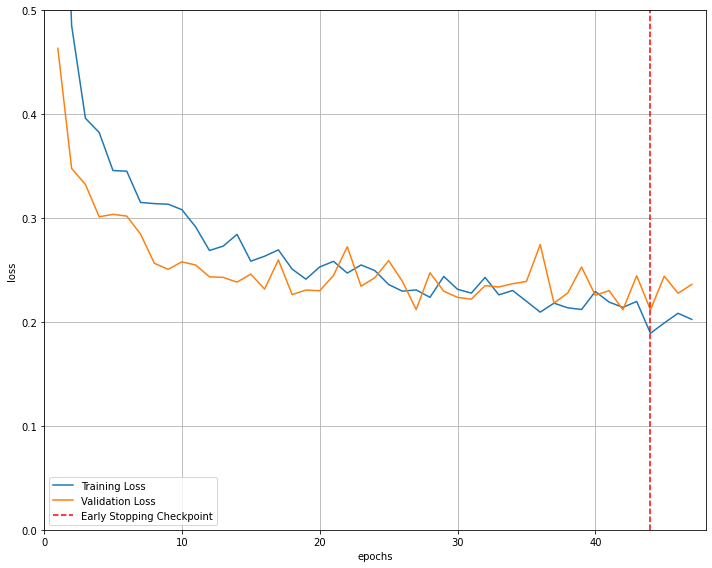

In [19]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

Este notebook foi adaptado do curso Deep Learning Nanodegree da Udacity, cujo repositório está disponível [aqui](https://github.com/udacity/deep-learning-v2-pytorch).

Referências:

- https://github.com/Bjarten/early-stopping-pytorch
- https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce 
- https://medium.com/the-deeplearning-guide/transfer-learning-in-pytorch-f7736598b1ed
- https://github.com/udacity/deep-learning-v2-pytorch/blob/master/transfer-learning/Transfer_Learning_Solution.ipynb
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html